In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=400 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = cm_target[-10:-7]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case13cm_blade1.csv', 'case14cm_blade1.csv', 'case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((n_cases,2,55,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,5))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (3000, 2)
Dimension - airfoil coordinates:  (6000, 50)
Dimension - coord with flaps:  (6000, 5)
Dimension - total coordinates:  (6000, 55)
Dimension - x_time:  (3000, 1)
Dimension - x_coordinates:  (3000, 2, 55, 1)
Dimension - y:  (3000, 1)


In [21]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [22]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [23]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [24]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,55,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='same', activation='relu',
                                     name='convLayer',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(input_coord)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [25]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 400)   2000        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 400)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 10800)        0           ['max_pooling2d[0][0]']          
                                                                                              

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20230102\\3Case(131415)(l2)"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20230102unsteady_AeroCNN1_3Case(131415)(l2)_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.1635 - rmse: 0.4042  
Epoch 1: val_loss improved from inf to 0.13943, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)20230102unsteady_AeroCNN1_3Case(131415)(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 9s 78ms/step - loss: 0.1642 - rmse: 0.4050 - val_loss: 0.1394 - val_rmse: 0.3732 - lr: 1.0000e-04
Epoch 2/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.1046 - rmse: 0.3232
Epoch 2: val_loss improved from 0.13943 to 0.06031, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)20230102unsteady_AeroCNN1_3Case(131415)(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.0907 - rmse: 0.3010 - val_loss: 0.0603 - val_rmse: 0.2453 - lr: 1.0000e-04
Epoch 3/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0688 - rmse: 0.2620
Epoch 3: val_lo

10/10 [==============================] - 0s 28ms/step - loss: 0.0579 - rmse: 0.2404 - val_loss: 0.0575 - val_rmse: 0.2394 - lr: 1.0000e-04
Epoch 22/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0560 - rmse: 0.2362
Epoch 22: val_loss did not improve from 0.05748
10/10 [==============================] - 0s 13ms/step - loss: 0.0558 - rmse: 0.2359 - val_loss: 0.0576 - val_rmse: 0.2398 - lr: 1.0000e-04
Epoch 23/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0565 - rmse: 0.2374
Epoch 23: val_loss improved from 0.05748 to 0.05719, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)20230102unsteady_AeroCNN1_3Case(131415)(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 29ms/step - loss: 0.0555 - rmse: 0.2353 - val_loss: 0.0572 - val_rmse: 0.2388 - lr: 1.0000e-04
Epoch 24/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0567 - rmse: 0.2378
Epoch 24: val_loss improved from 0.05

Epoch 42/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0499 - rmse: 0.2231
Epoch 42: val_loss improved from 0.05179 to 0.05176, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)20230102unsteady_AeroCNN1_3Case(131415)(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 25ms/step - loss: 0.0501 - rmse: 0.2235 - val_loss: 0.0518 - val_rmse: 0.2272 - lr: 1.0000e-04
Epoch 43/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0501 - rmse: 0.2235
Epoch 43: val_loss improved from 0.05176 to 0.05078, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)20230102unsteady_AeroCNN1_3Case(131415)(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 30ms/step - loss: 0.0504 - rmse: 0.2241 - val_loss: 0.0508 - val_rmse: 0.2250 - lr: 1.0000e-04
Epoch 44/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0511 - rmse: 0.2258
Epoch 44

10/10 [==============================] - 0s 27ms/step - loss: 0.0177 - rmse: 0.1326 - val_loss: 0.0170 - val_rmse: 0.1297 - lr: 1.0000e-04
Epoch 61/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0152 - rmse: 0.1229
Epoch 61: val_loss improved from 0.01698 to 0.01413, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)20230102unsteady_AeroCNN1_3Case(131415)(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 28ms/step - loss: 0.0157 - rmse: 0.1246 - val_loss: 0.0141 - val_rmse: 0.1182 - lr: 1.0000e-04
Epoch 62/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0126 - rmse: 0.1118
Epoch 62: val_loss improved from 0.01413 to 0.01238, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)20230102unsteady_AeroCNN1_3Case(131415)(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 29ms/step - loss: 0.0128 - rmse: 0.1123 - val_loss: 0.0124

Epoch 81/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0025 - rmse: 0.0481
Epoch 81: val_loss improved from 0.00250 to 0.00220, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)20230102unsteady_AeroCNN1_3Case(131415)(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 25ms/step - loss: 0.0023 - rmse: 0.0464 - val_loss: 0.0022 - val_rmse: 0.0453 - lr: 1.0000e-04
Epoch 82/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0022 - rmse: 0.0456
Epoch 82: val_loss improved from 0.00220 to 0.00203, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)20230102unsteady_AeroCNN1_3Case(131415)(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.0022 - rmse: 0.0449 - val_loss: 0.0020 - val_rmse: 0.0434 - lr: 1.0000e-04
Epoch 83/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0022 - rmse: 0.0448
Epoch 83

Epoch 101/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0010 - rmse: 0.0298
Epoch 101: val_loss improved from 0.00104 to 0.00098, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)20230102unsteady_AeroCNN1_3Case(131415)(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 31ms/step - loss: 0.0011 - rmse: 0.0308 - val_loss: 9.8371e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 102/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0299    
Epoch 102: val_loss did not improve from 0.00098
10/10 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0301 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 103/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0307
Epoch 103: val_loss did not improve from 0.00098
10/10 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0304 - val_loss: 0.0011 - val_rmse:

10/10 [==============================] - 0s 29ms/step - loss: 5.9248e-04 - rmse: 0.0212 - val_loss: 5.8780e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 124/10000
 7/10 [====================>.........] - ETA: 0s - loss: 6.2512e-04 - rmse: 0.0219
Epoch 124: val_loss did not improve from 0.00059
10/10 [==============================] - 0s 13ms/step - loss: 6.3770e-04 - rmse: 0.0222 - val_loss: 5.9000e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 125/10000
 7/10 [====================>.........] - ETA: 0s - loss: 6.0354e-04 - rmse: 0.0215
Epoch 125: val_loss did not improve from 0.00059
10/10 [==============================] - 0s 13ms/step - loss: 6.0666e-04 - rmse: 0.0215 - val_loss: 6.4376e-04 - val_rmse: 0.0224 - lr: 1.0000e-04
Epoch 126/10000
 7/10 [====================>.........] - ETA: 0s - loss: 6.0526e-04 - rmse: 0.0215
Epoch 126: val_loss did not improve from 0.00059
10/10 [==============================] - 0s 13ms/step - loss: 6.1943e-04 - rmse: 0.0218 - val_loss: 6.0398e-04 - va

10/10 [==============================] - 0s 28ms/step - loss: 4.5259e-04 - rmse: 0.0177 - val_loss: 4.6288e-04 - val_rmse: 0.0180 - lr: 1.0000e-04
Epoch 148/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.0215e-04 - rmse: 0.0190
Epoch 148: val_loss did not improve from 0.00046
10/10 [==============================] - 0s 12ms/step - loss: 5.0598e-04 - rmse: 0.0191 - val_loss: 5.7281e-04 - val_rmse: 0.0208 - lr: 1.0000e-04
Epoch 149/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8230e-04 - rmse: 0.0185
Epoch 149: val_loss did not improve from 0.00046
10/10 [==============================] - 0s 12ms/step - loss: 4.8391e-04 - rmse: 0.0185 - val_loss: 5.3374e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 150/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8166e-04 - rmse: 0.0185
Epoch 150: val_loss did not improve from 0.00046
10/10 [==============================] - 0s 13ms/step - loss: 4.7917e-04 - rmse: 0.0184 - val_loss: 5.0565e-04 - va

Epoch 174/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.2865e-04 - rmse: 0.0171
Epoch 174: val_loss did not improve from 0.00041
10/10 [==============================] - 0s 13ms/step - loss: 4.5476e-04 - rmse: 0.0178 - val_loss: 5.8470e-04 - val_rmse: 0.0212 - lr: 1.0000e-04
Epoch 175/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.2472e-04 - rmse: 0.0197
Epoch 175: val_loss did not improve from 0.00041
10/10 [==============================] - 0s 12ms/step - loss: 5.7524e-04 - rmse: 0.0209 - val_loss: 4.9328e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 176/10000
 7/10 [====================>.........] - ETA: 0s - loss: 6.0762e-04 - rmse: 0.0217
Epoch 176: val_loss did not improve from 0.00041
10/10 [==============================] - 0s 12ms/step - loss: 5.8332e-04 - rmse: 0.0211 - val_loss: 6.0254e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 177/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.8353e-04 - rmse: 0.0211
Epoch 177: val_l

Epoch 199/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.4805e-04 - rmse: 0.0177
Epoch 199: val_loss improved from 0.00039 to 0.00038, saving model to D:\TrainedModels\20230102\3Case(131415)(l2)20230102unsteady_AeroCNN1_3Case(131415)(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 4.3149e-04 - rmse: 0.0172 - val_loss: 3.7960e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 200/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9669e-04 - rmse: 0.0162
Epoch 200: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 13ms/step - loss: 3.8874e-04 - rmse: 0.0160 - val_loss: 4.5106e-04 - val_rmse: 0.0178 - lr: 1.0000e-04
Epoch 201/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.4718e-04 - rmse: 0.0177
Epoch 201: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 13ms/step - loss: 4.5468e-04 - rmse: 0.0179 - val_

 7/10 [====================>.........] - ETA: 0s - loss: 4.5574e-04 - rmse: 0.0180
Epoch 225: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 13ms/step - loss: 4.4656e-04 - rmse: 0.0178 - val_loss: 4.3204e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 226/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.0493e-04 - rmse: 0.0166
Epoch 226: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 12ms/step - loss: 4.1077e-04 - rmse: 0.0167 - val_loss: 4.1843e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 227/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.1733e-04 - rmse: 0.0169
Epoch 227: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 12ms/step - loss: 4.1002e-04 - rmse: 0.0167 - val_loss: 4.0582e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 228/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.0193e-04 - rmse: 0.0165
Epoch 228: val_loss did not impr

Epoch 253/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7990e-04 - rmse: 0.0159
Epoch 253: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 12ms/step - loss: 4.0559e-04 - rmse: 0.0167 - val_loss: 4.0572e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 254/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.9069e-04 - rmse: 0.0191
Epoch 254: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 12ms/step - loss: 4.6668e-04 - rmse: 0.0184 - val_loss: 4.3960e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 255/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8429e-04 - rmse: 0.0160
Epoch 255: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 12ms/step - loss: 4.0472e-04 - rmse: 0.0167 - val_loss: 4.8960e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 256/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.6511e-04 - rmse: 0.0184
Epoch 256: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 4.0364e-04 - rmse: 0.0167
Epoch 280: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 13ms/step - loss: 3.8492e-04 - rmse: 0.0161 - val_loss: 3.9306e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 281/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.1428e-04 - rmse: 0.0198
Epoch 281: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 5.6414e-04 - rmse: 0.0210 - val_loss: 9.7349e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 282/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.3800e-04 - rmse: 0.0248
Epoch 282: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 6.8954e-04 - rmse: 0.0238 - val_loss: 4.1778e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 283/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8142e-04 - rmse: 0.0189
Epoch 283: val_loss did not impr

Epoch 307/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8707e-04 - rmse: 0.0191
Epoch 307: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 4.8678e-04 - rmse: 0.0191 - val_loss: 4.6692e-04 - val_rmse: 0.0186 - lr: 1.0000e-04
Epoch 308/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.5686e-04 - rmse: 0.0183
Epoch 308: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 4.6197e-04 - rmse: 0.0185 - val_loss: 5.1870e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 309/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.9269e-04 - rmse: 0.0193
Epoch 309: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 4.8197e-04 - rmse: 0.0190 - val_loss: 5.2735e-04 - val_rmse: 0.0202 - lr: 1.0000e-04
Epoch 310/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8582e-04 - rmse: 0.0191
Epoch 310: val_l

Epoch 335/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9807e-04 - rmse: 0.0167
Epoch 335: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 3.8791e-04 - rmse: 0.0164 - val_loss: 3.6992e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 336/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9698e-04 - rmse: 0.0167
Epoch 336: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 3.7982e-04 - rmse: 0.0162 - val_loss: 3.8965e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 337/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.1079e-04 - rmse: 0.0171
Epoch 337: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 4.0220e-04 - rmse: 0.0169 - val_loss: 3.4714e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 338/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6992e-04 - rmse: 0.0159
Epoch 338: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 4.3077e-04 - rmse: 0.0178
Epoch 362: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 4.6431e-04 - rmse: 0.0187 - val_loss: 5.0673e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 363/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.3111e-04 - rmse: 0.0204
Epoch 363: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 13ms/step - loss: 5.6941e-04 - rmse: 0.0213 - val_loss: 5.5630e-04 - val_rmse: 0.0210 - lr: 1.0000e-04
Epoch 364/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.2884e-04 - rmse: 0.0203
Epoch 364: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 5.2973e-04 - rmse: 0.0204 - val_loss: 5.3819e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 365/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.2848e-04 - rmse: 0.0203
Epoch 365: val_loss did not impr

Epoch 390/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3412e-04 - rmse: 0.0149
Epoch 390: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 3.4319e-04 - rmse: 0.0152 - val_loss: 4.1501e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 391/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.1816e-04 - rmse: 0.0175
Epoch 391: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 4.2998e-04 - rmse: 0.0178 - val_loss: 4.3305e-04 - val_rmse: 0.0179 - lr: 1.0000e-04
Epoch 392/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.3980e-04 - rmse: 0.0181
Epoch 392: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 4.5519e-04 - rmse: 0.0185 - val_loss: 4.8219e-04 - val_rmse: 0.0192 - lr: 1.0000e-04
Epoch 393/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.0031e-04 - rmse: 0.0170
Epoch 393: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 3.2764e-04 - rmse: 0.0147
Epoch 417: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.6620e-04 - rmse: 0.0160 - val_loss: 4.0231e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 418/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9220e-04 - rmse: 0.0168
Epoch 418: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.9737e-04 - rmse: 0.0170 - val_loss: 4.3947e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 419/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.3741e-04 - rmse: 0.0181
Epoch 419: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 4.2019e-04 - rmse: 0.0176 - val_loss: 3.5323e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 420/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.3946e-04 - rmse: 0.0182
Epoch 420: val_loss did not impr

 7/10 [====================>.........] - ETA: 0s - loss: 3.7075e-04 - rmse: 0.0162
Epoch 444: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.5694e-04 - rmse: 0.0158 - val_loss: 3.5704e-04 - val_rmse: 0.0158 - lr: 1.0000e-04
Epoch 445/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6087e-04 - rmse: 0.0159
Epoch 445: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.6357e-04 - rmse: 0.0160 - val_loss: 3.3346e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 446/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4471e-04 - rmse: 0.0154
Epoch 446: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.5589e-04 - rmse: 0.0158 - val_loss: 3.4384e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 447/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2819e-04 - rmse: 0.0149
Epoch 447: val_loss did not impr

Epoch 471/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6444e-04 - rmse: 0.0161
Epoch 471: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.6825e-04 - rmse: 0.0162 - val_loss: 3.7000e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 472/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8229e-04 - rmse: 0.0166
Epoch 472: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.9722e-04 - rmse: 0.0171 - val_loss: 4.0249e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 473/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6028e-04 - rmse: 0.0160
Epoch 473: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.6983e-04 - rmse: 0.0163 - val_loss: 3.2159e-04 - val_rmse: 0.0147 - lr: 1.0000e-04
Epoch 474/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.0808e-04 - rmse: 0.0174
Epoch 474: val_l

Epoch 499/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4828e-04 - rmse: 0.0157
Epoch 499: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.5564e-04 - rmse: 0.0159 - val_loss: 3.8477e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 500/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7855e-04 - rmse: 0.0166
Epoch 500: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.6454e-04 - rmse: 0.0162 - val_loss: 3.2115e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 501/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5696e-04 - rmse: 0.0159
Epoch 501: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.6283e-04 - rmse: 0.0161 - val_loss: 4.3311e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 502/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.3457e-04 - rmse: 0.0182
Epoch 502: val_l

Epoch 527/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.0547e-04 - rmse: 0.0201
Epoch 527: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 4.9651e-04 - rmse: 0.0199 - val_loss: 4.7320e-04 - val_rmse: 0.0193 - lr: 1.0000e-04
Epoch 528/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.6063e-04 - rmse: 0.0190
Epoch 528: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 4.5913e-04 - rmse: 0.0189 - val_loss: 5.2318e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 529/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.5222e-04 - rmse: 0.0187
Epoch 529: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 4.4780e-04 - rmse: 0.0186 - val_loss: 4.0420e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 530/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.2659e-04 - rmse: 0.0181
Epoch 530: val_l

Epoch 555/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5830e-04 - rmse: 0.0161
Epoch 555: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.5435e-04 - rmse: 0.0160 - val_loss: 3.5316e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 556/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5271e-04 - rmse: 0.0159
Epoch 556: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.6123e-04 - rmse: 0.0162 - val_loss: 3.5406e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 557/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.5944e-04 - rmse: 0.0162
Epoch 557: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.5436e-04 - rmse: 0.0160 - val_loss: 3.3704e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 558/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9427e-04 - rmse: 0.0172
Epoch 558: val_l

Epoch 583/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6686e-04 - rmse: 0.0164
Epoch 583: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 13ms/step - loss: 3.7784e-04 - rmse: 0.0168 - val_loss: 3.6708e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 584/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8113e-04 - rmse: 0.0169
Epoch 584: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.8237e-04 - rmse: 0.0169 - val_loss: 4.6397e-04 - val_rmse: 0.0192 - lr: 1.0000e-04
Epoch 585/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8448e-04 - rmse: 0.0170
Epoch 585: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.8080e-04 - rmse: 0.0169 - val_loss: 3.2360e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 586/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5499e-04 - rmse: 0.0161
Epoch 586: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 4.0967e-04 - rmse: 0.0177
Epoch 610: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.9669e-04 - rmse: 0.0174 - val_loss: 3.5843e-04 - val_rmse: 0.0162 - lr: 1.0000e-04
Epoch 611/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4375e-04 - rmse: 0.0158
Epoch 611: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.4192e-04 - rmse: 0.0157 - val_loss: 3.7318e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 612/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5269e-04 - rmse: 0.0161
Epoch 612: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 12ms/step - loss: 3.4935e-04 - rmse: 0.0160 - val_loss: 3.2345e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 613/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4553e-04 - rmse: 0.0158
Epoch 613: val_loss did not impr

Epoch 637/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.0334e-04 - rmse: 0.0203
Epoch 637: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 5.0703e-04 - rmse: 0.0203 - val_loss: 3.5602e-04 - val_rmse: 0.0162 - lr: 1.0000e-04
Epoch 638/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.0485e-04 - rmse: 0.0177
Epoch 638: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.0569e-04 - rmse: 0.0177 - val_loss: 5.1663e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 639/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8510e-04 - rmse: 0.0198
Epoch 639: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 13ms/step - loss: 4.5937e-04 - rmse: 0.0191 - val_loss: 5.5076e-04 - val_rmse: 0.0214 - lr: 1.0000e-04
Epoch 640/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.2316e-04 - rmse: 0.0182
Epoch 640: val_l

Epoch 665/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8231e-04 - rmse: 0.0198
Epoch 665: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.8031e-04 - rmse: 0.0197 - val_loss: 4.9994e-04 - val_rmse: 0.0202 - lr: 1.0000e-04
Epoch 666/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8005e-04 - rmse: 0.0197
Epoch 666: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.8881e-04 - rmse: 0.0199 - val_loss: 4.0039e-04 - val_rmse: 0.0176 - lr: 1.0000e-04
Epoch 667/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.1599e-04 - rmse: 0.0180
Epoch 667: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.3649e-04 - rmse: 0.0186 - val_loss: 5.9575e-04 - val_rmse: 0.0225 - lr: 1.0000e-04
Epoch 668/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.5874e-04 - rmse: 0.0192
Epoch 668: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 5.2374e-04 - rmse: 0.0208
Epoch 692: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 13ms/step - loss: 5.1177e-04 - rmse: 0.0205 - val_loss: 5.5534e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 693/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.6198e-04 - rmse: 0.0193
Epoch 693: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 13ms/step - loss: 4.6763e-04 - rmse: 0.0194 - val_loss: 5.1142e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 694/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.4831e-04 - rmse: 0.0189
Epoch 694: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 13ms/step - loss: 4.4323e-04 - rmse: 0.0188 - val_loss: 4.0729e-04 - val_rmse: 0.0178 - lr: 1.0000e-04
Epoch 695/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8118e-04 - rmse: 0.0171
Epoch 695: val_loss did not impr

Epoch 720/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3671e-04 - rmse: 0.0158
Epoch 720: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 13ms/step - loss: 3.2541e-04 - rmse: 0.0154 - val_loss: 3.1812e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 721/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0698e-04 - rmse: 0.0148
Epoch 721: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.2257e-04 - rmse: 0.0153 - val_loss: 3.6907e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 722/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4445e-04 - rmse: 0.0160
Epoch 722: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.5625e-04 - rmse: 0.0164 - val_loss: 3.4757e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 723/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1985e-04 - rmse: 0.0152
Epoch 723: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 3.8657e-04 - rmse: 0.0173
Epoch 747: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 13ms/step - loss: 3.9404e-04 - rmse: 0.0175 - val_loss: 4.9093e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 748/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.0142e-04 - rmse: 0.0204
Epoch 748: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 13ms/step - loss: 4.9855e-04 - rmse: 0.0203 - val_loss: 5.8934e-04 - val_rmse: 0.0224 - lr: 1.0000e-04
Epoch 749/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.5316e-04 - rmse: 0.0192
Epoch 749: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 13ms/step - loss: 4.5427e-04 - rmse: 0.0192 - val_loss: 3.9721e-04 - val_rmse: 0.0176 - lr: 1.0000e-04
Epoch 750/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6136e-04 - rmse: 0.0166
Epoch 750: val_loss did not impr

 7/10 [====================>.........] - ETA: 0s - loss: 3.4974e-04 - rmse: 0.0163
Epoch 774: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 13ms/step - loss: 3.5210e-04 - rmse: 0.0163 - val_loss: 3.3211e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 775/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5811e-04 - rmse: 0.0165
Epoch 775: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.9533e-04 - rmse: 0.0176 - val_loss: 4.6799e-04 - val_rmse: 0.0196 - lr: 1.0000e-04
Epoch 776/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.2367e-04 - rmse: 0.0184
Epoch 776: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 4.1220e-04 - rmse: 0.0181 - val_loss: 3.6343e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 777/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2674e-04 - rmse: 0.0156
Epoch 777: val_loss did not impr

Epoch 802/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8639e-04 - rmse: 0.0174
Epoch 802: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.6227e-04 - rmse: 0.0167 - val_loss: 3.0589e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 803/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1328e-04 - rmse: 0.0152
Epoch 803: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.1620e-04 - rmse: 0.0153 - val_loss: 2.9336e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 804/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3635e-04 - rmse: 0.0159
Epoch 804: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.3148e-04 - rmse: 0.0157 - val_loss: 3.4358e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 805/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2676e-04 - rmse: 0.0156
Epoch 805: val_l

Epoch 830/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4130e-04 - rmse: 0.0161
Epoch 830: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 13ms/step - loss: 3.3310e-04 - rmse: 0.0158 - val_loss: 3.0534e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 831/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0929e-04 - rmse: 0.0151
Epoch 831: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.0238e-04 - rmse: 0.0148 - val_loss: 3.2047e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 832/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9859e-04 - rmse: 0.0147
Epoch 832: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.0418e-04 - rmse: 0.0149 - val_loss: 3.3409e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 833/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2427e-04 - rmse: 0.0156
Epoch 833: val_l

Epoch 858/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3270e-04 - rmse: 0.0159
Epoch 858: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.1993e-04 - rmse: 0.0155 - val_loss: 3.2976e-04 - val_rmse: 0.0158 - lr: 1.0000e-04
Epoch 859/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2782e-04 - rmse: 0.0157
Epoch 859: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.4349e-04 - rmse: 0.0162 - val_loss: 3.2432e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 860/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3896e-04 - rmse: 0.0161
Epoch 860: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 13ms/step - loss: 3.4240e-04 - rmse: 0.0162 - val_loss: 3.7576e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 861/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7070e-04 - rmse: 0.0170
Epoch 861: val_l

Epoch 886/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.1675e-04 - rmse: 0.0184
Epoch 886: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 4.0216e-04 - rmse: 0.0180 - val_loss: 3.7854e-04 - val_rmse: 0.0173 - lr: 1.0000e-04
Epoch 887/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6907e-04 - rmse: 0.0170
Epoch 887: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.6987e-04 - rmse: 0.0170 - val_loss: 3.9120e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 888/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6127e-04 - rmse: 0.0168
Epoch 888: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.7015e-04 - rmse: 0.0170 - val_loss: 3.0576e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 889/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3430e-04 - rmse: 0.0160
Epoch 889: val_l

Epoch 913/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4055e-04 - rmse: 0.0162
Epoch 913: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.2067e-04 - rmse: 0.0156 - val_loss: 3.2146e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 914/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1379e-04 - rmse: 0.0153
Epoch 914: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.0677e-04 - rmse: 0.0151 - val_loss: 3.0247e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 915/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2250e-04 - rmse: 0.0156
Epoch 915: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 13ms/step - loss: 3.4981e-04 - rmse: 0.0165 - val_loss: 2.9436e-04 - val_rmse: 0.0147 - lr: 1.0000e-04
Epoch 916/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4833e-04 - rmse: 0.0164
Epoch 916: val_l

10/10 [==============================] - 0s 12ms/step - loss: 2.9457e-04 - rmse: 0.0147 - val_loss: 2.7807e-04 - val_rmse: 0.0142 - lr: 5.0000e-05
Epoch 940/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0124e-04 - rmse: 0.0150
Epoch 940: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.9358e-04 - rmse: 0.0147 - val_loss: 2.7987e-04 - val_rmse: 0.0142 - lr: 5.0000e-05
Epoch 941/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8339e-04 - rmse: 0.0143
Epoch 941: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.8089e-04 - rmse: 0.0143 - val_loss: 2.8219e-04 - val_rmse: 0.0143 - lr: 5.0000e-05
Epoch 942/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9035e-04 - rmse: 0.0146
Epoch 942: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.7948e-04 - rmse: 0.0142 - val_loss: 2.7201e-04 - va

 7/10 [====================>.........] - ETA: 0s - loss: 2.9603e-04 - rmse: 0.0148
Epoch 966: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.9354e-04 - rmse: 0.0147 - val_loss: 3.0663e-04 - val_rmse: 0.0152 - lr: 5.0000e-05
Epoch 967/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8928e-04 - rmse: 0.0146
Epoch 967: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.7855e-04 - rmse: 0.0142 - val_loss: 2.8595e-04 - val_rmse: 0.0145 - lr: 5.0000e-05
Epoch 968/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8312e-04 - rmse: 0.0144
Epoch 968: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.8737e-04 - rmse: 0.0145 - val_loss: 3.1412e-04 - val_rmse: 0.0154 - lr: 5.0000e-05
Epoch 969/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1902e-04 - rmse: 0.0156
Epoch 969: val_loss did not impr

Epoch 994/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2490e-04 - rmse: 0.0158
Epoch 994: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.2271e-04 - rmse: 0.0157 - val_loss: 3.1685e-04 - val_rmse: 0.0155 - lr: 5.0000e-05
Epoch 995/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1310e-04 - rmse: 0.0154
Epoch 995: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.0719e-04 - rmse: 0.0152 - val_loss: 2.8308e-04 - val_rmse: 0.0144 - lr: 5.0000e-05
Epoch 996/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8470e-04 - rmse: 0.0144
Epoch 996: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.9125e-04 - rmse: 0.0147 - val_loss: 3.1980e-04 - val_rmse: 0.0156 - lr: 5.0000e-05
Epoch 997/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8759e-04 - rmse: 0.0145
Epoch 997: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 2.7968e-04 - rmse: 0.0143
Epoch 1021: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.8057e-04 - rmse: 0.0143 - val_loss: 2.9209e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 1022/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1326e-04 - rmse: 0.0154
Epoch 1022: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.0223e-04 - rmse: 0.0150 - val_loss: 3.2750e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 1023/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0904e-04 - rmse: 0.0153
Epoch 1023: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.0348e-04 - rmse: 0.0151 - val_loss: 2.6900e-04 - val_rmse: 0.0139 - lr: 5.0000e-05
Epoch 1024/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8853e-04 - rmse: 0.0146
Epoch 1024: val_loss did n

Epoch 1049/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3065e-04 - rmse: 0.0160
Epoch 1049: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.1386e-04 - rmse: 0.0154 - val_loss: 2.9227e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 1050/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2981e-04 - rmse: 0.0160
Epoch 1050: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.2453e-04 - rmse: 0.0158 - val_loss: 3.1460e-04 - val_rmse: 0.0155 - lr: 5.0000e-05
Epoch 1051/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3092e-04 - rmse: 0.0160
Epoch 1051: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.2233e-04 - rmse: 0.0157 - val_loss: 2.7386e-04 - val_rmse: 0.0141 - lr: 5.0000e-05
Epoch 1052/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0449e-04 - rmse: 0.0151
Epoch 105

Epoch 1077/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1473e-04 - rmse: 0.0155
Epoch 1077: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.9914e-04 - rmse: 0.0150 - val_loss: 3.3386e-04 - val_rmse: 0.0161 - lr: 5.0000e-05
Epoch 1078/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3237e-04 - rmse: 0.0161
Epoch 1078: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.2331e-04 - rmse: 0.0158 - val_loss: 3.0354e-04 - val_rmse: 0.0151 - lr: 5.0000e-05
Epoch 1079/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9631e-04 - rmse: 0.0149
Epoch 1079: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 13ms/step - loss: 2.9734e-04 - rmse: 0.0149 - val_loss: 2.7649e-04 - val_rmse: 0.0142 - lr: 5.0000e-05
Epoch 1080/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9176e-04 - rmse: 0.0147
Epoch 108

Epoch 1105/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5609e-04 - rmse: 0.0168
Epoch 1105: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.5382e-04 - rmse: 0.0167 - val_loss: 2.8054e-04 - val_rmse: 0.0144 - lr: 5.0000e-05
Epoch 1106/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8365e-04 - rmse: 0.0145
Epoch 1106: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.8206e-04 - rmse: 0.0144 - val_loss: 3.2188e-04 - val_rmse: 0.0157 - lr: 5.0000e-05
Epoch 1107/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2460e-04 - rmse: 0.0158
Epoch 1107: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.2436e-04 - rmse: 0.0158 - val_loss: 3.0265e-04 - val_rmse: 0.0151 - lr: 5.0000e-05
Epoch 1108/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9712e-04 - rmse: 0.0149
Epoch 110

Epoch 1133/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8362e-04 - rmse: 0.0145
Epoch 1133: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.8448e-04 - rmse: 0.0145 - val_loss: 2.8971e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 1134/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6911e-04 - rmse: 0.0140
Epoch 1134: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.9071e-04 - rmse: 0.0147 - val_loss: 2.8470e-04 - val_rmse: 0.0145 - lr: 5.0000e-05
Epoch 1135/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8392e-04 - rmse: 0.0145
Epoch 1135: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.7949e-04 - rmse: 0.0144 - val_loss: 2.6626e-04 - val_rmse: 0.0139 - lr: 5.0000e-05
Epoch 1136/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7235e-04 - rmse: 0.0141
Epoch 113

Epoch 1161/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9760e-04 - rmse: 0.0150
Epoch 1161: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.9190e-04 - rmse: 0.0148 - val_loss: 3.1665e-04 - val_rmse: 0.0156 - lr: 5.0000e-05
Epoch 1162/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1389e-04 - rmse: 0.0155
Epoch 1162: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.0962e-04 - rmse: 0.0154 - val_loss: 3.0867e-04 - val_rmse: 0.0154 - lr: 5.0000e-05
Epoch 1163/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9635e-04 - rmse: 0.0149
Epoch 1163: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.0556e-04 - rmse: 0.0153 - val_loss: 2.7911e-04 - val_rmse: 0.0144 - lr: 5.0000e-05
Epoch 1164/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9534e-04 - rmse: 0.0149
Epoch 116

Epoch 1189/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0628e-04 - rmse: 0.0153
Epoch 1189: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 13ms/step - loss: 2.9630e-04 - rmse: 0.0150 - val_loss: 2.8413e-04 - val_rmse: 0.0145 - lr: 5.0000e-05
Epoch 1190/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8305e-04 - rmse: 0.0145
Epoch 1190: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.8193e-04 - rmse: 0.0145 - val_loss: 2.8808e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 1191/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1613e-04 - rmse: 0.0156
Epoch 1191: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.1975e-04 - rmse: 0.0157 - val_loss: 3.2598e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 1192/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9011e-04 - rmse: 0.0148
Epoch 119

Epoch 1216/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6620e-04 - rmse: 0.0139
Epoch 1216: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6446e-04 - rmse: 0.0139 - val_loss: 2.6730e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 1217/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6518e-04 - rmse: 0.0139
Epoch 1217: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6937e-04 - rmse: 0.0140 - val_loss: 2.7230e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 1218/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7093e-04 - rmse: 0.0141
Epoch 1218: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5962e-04 - rmse: 0.0137 - val_loss: 2.7935e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 1219/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9101e-04 - rmse: 0.0148
Epoch 121

 7/10 [====================>.........] - ETA: 0s - loss: 2.7724e-04 - rmse: 0.0143
Epoch 1243: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.7699e-04 - rmse: 0.0143 - val_loss: 2.8114e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 1244/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7605e-04 - rmse: 0.0143
Epoch 1244: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6932e-04 - rmse: 0.0141 - val_loss: 2.7382e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 1245/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7562e-04 - rmse: 0.0143
Epoch 1245: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.7406e-04 - rmse: 0.0142 - val_loss: 2.7262e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 1246/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6116e-04 - rmse: 0.0138
Epoch 1246: val_loss did n

Epoch 1271/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5404e-04 - rmse: 0.0135
Epoch 1271: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6834e-04 - rmse: 0.0140 - val_loss: 2.6879e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 1272/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6926e-04 - rmse: 0.0141
Epoch 1272: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6619e-04 - rmse: 0.0140 - val_loss: 2.7790e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 1273/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8510e-04 - rmse: 0.0146
Epoch 1273: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.9393e-04 - rmse: 0.0149 - val_loss: 2.8143e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 1274/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6933e-04 - rmse: 0.0141
Epoch 127

Epoch 1299/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9261e-04 - rmse: 0.0149
Epoch 1299: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 13ms/step - loss: 2.8179e-04 - rmse: 0.0145 - val_loss: 2.9716e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 1300/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7058e-04 - rmse: 0.0141
Epoch 1300: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 13ms/step - loss: 2.9120e-04 - rmse: 0.0148 - val_loss: 2.6666e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 1301/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8886e-04 - rmse: 0.0148
Epoch 1301: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.9497e-04 - rmse: 0.0150 - val_loss: 3.0724e-04 - val_rmse: 0.0154 - lr: 2.5000e-05
Epoch 1302/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1839e-04 - rmse: 0.0157
Epoch 130

Epoch 1327/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6217e-04 - rmse: 0.0138
Epoch 1327: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6668e-04 - rmse: 0.0140 - val_loss: 2.6354e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 1328/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5907e-04 - rmse: 0.0137
Epoch 1328: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6841e-04 - rmse: 0.0141 - val_loss: 2.7853e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 1329/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6007e-04 - rmse: 0.0138
Epoch 1329: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5848e-04 - rmse: 0.0137 - val_loss: 2.6364e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 1330/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7021e-04 - rmse: 0.0141
Epoch 133

 7/10 [====================>.........] - ETA: 0s - loss: 2.7154e-04 - rmse: 0.0142
Epoch 1354: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6857e-04 - rmse: 0.0141 - val_loss: 2.8085e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 1355/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7768e-04 - rmse: 0.0144
Epoch 1355: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.7418e-04 - rmse: 0.0143 - val_loss: 2.7499e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 1356/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6430e-04 - rmse: 0.0139
Epoch 1356: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 13ms/step - loss: 2.7018e-04 - rmse: 0.0141 - val_loss: 2.6188e-04 - val_rmse: 0.0138 - lr: 2.5000e-05
Epoch 1357/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8088e-04 - rmse: 0.0145
Epoch 1357: val_loss did n

Epoch 1382/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8429e-04 - rmse: 0.0146
Epoch 1382: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.8749e-04 - rmse: 0.0147 - val_loss: 2.7871e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 1383/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7871e-04 - rmse: 0.0144
Epoch 1383: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.8190e-04 - rmse: 0.0145 - val_loss: 2.6621e-04 - val_rmse: 0.0140 - lr: 2.5000e-05
Epoch 1384/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6138e-04 - rmse: 0.0138
Epoch 1384: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5967e-04 - rmse: 0.0138 - val_loss: 2.7380e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 1385/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6829e-04 - rmse: 0.0141
Epoch 138

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:03:20.394964


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230102_AeroCNN1_3Case(131415)(l2)_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

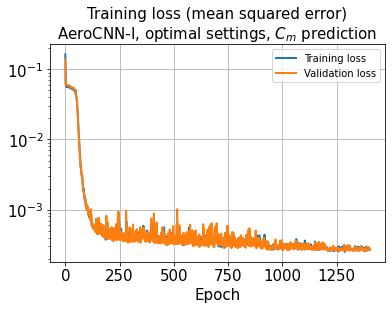

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

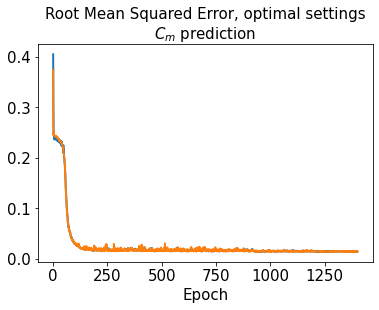

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

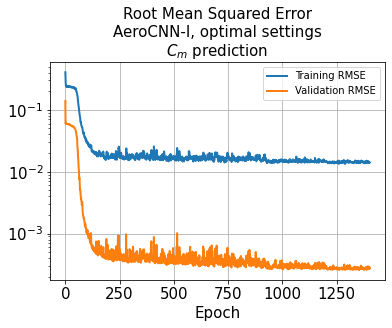

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

66/66 [==============================] - 0s 4ms/step - loss: 2.6697e-04 - rmse: 0.0138


In [37]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

19/19 [==============================] - 0s 5ms/step - loss: 2.6314e-04 - rmse: 0.0137


In [38]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

10/10 [==============================] - 0s 5ms/step - loss: 3.2580e-04 - rmse: 0.0158


In [39]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

10/10 [==============================] - 0s 2ms/step


In [40]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.03201061450581622
1.2160072528299297


In [46]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.030955383098477045
1.2022758442053927


In [47]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.03481597528982074
1.264267769013206


In [48]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [49]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [50]:
model_directory = "D:\\TrainedModels\\20230102"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20230102unsteady_AeroCNN1_3Case(131415)(l2)_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [52]:
os.chdir(storage_dir)

In [53]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [56]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [57]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [58]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [59]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

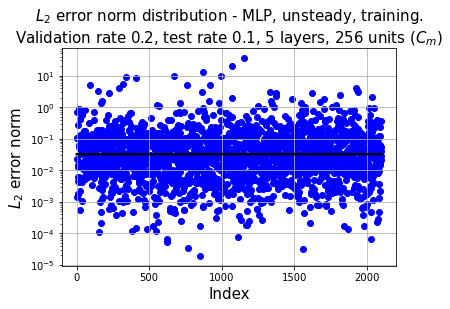

In [60]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

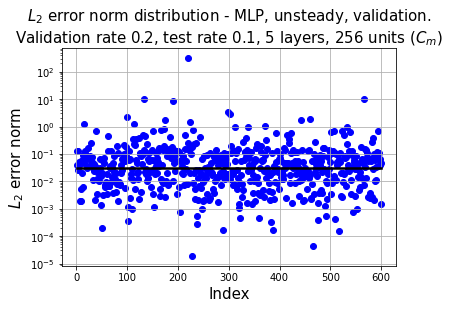

In [61]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

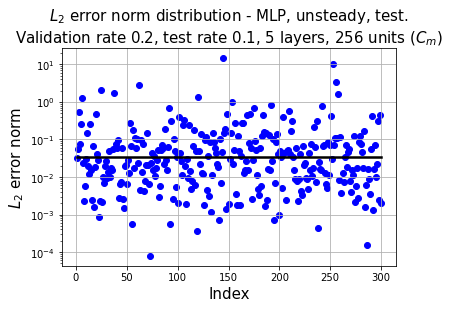

In [62]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [63]:
predicted = model.predict([x_time, x_coord])

94/94 [==============================] - 0s 3ms/step


In [64]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [65]:
max(predicted)

array([0.9795155], dtype=float32)

In [66]:
print(l2_error(predicted, y))

0.03211470305606649


In [67]:
cm[2000]

array([0.00682824])

In [68]:
cm[1000]

array([0.0014248])

In [69]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [70]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [71]:
t

array([[0.   ],
       [0.001],
       [0.002],
       ...,
       [0.997],
       [0.998],
       [0.999]])

In [72]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [73]:
len(predicted[index_train])

2101

In [74]:
len(predicted[index_val])

601

In [75]:
len(predicted[index_test])

300

In [76]:
x_time += 10

L2 error of Cm: 0.0354


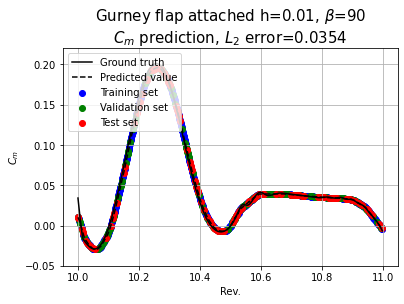

L2 error of Cm: 0.0383


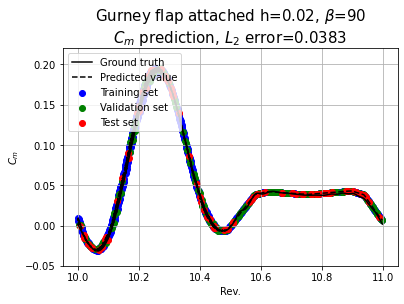

L2 error of Cm: 0.0183


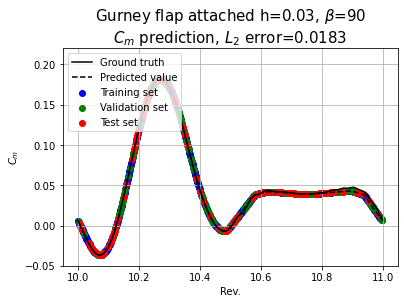

In [77]:
h = [0.01, 0.02, 0.03]
beta = [90, 90, 90]
for i in range(0,3):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [86]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    plt.xlim([10.17, 10.23])
    plt.ylim([0.11, 0.15])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0354


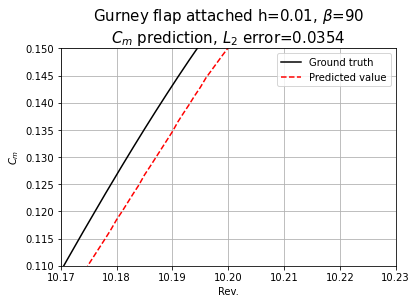

L2 error of Cm: 0.0383


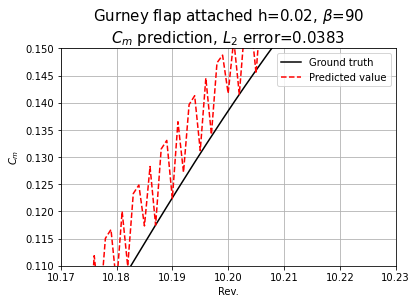

L2 error of Cm: 0.0183


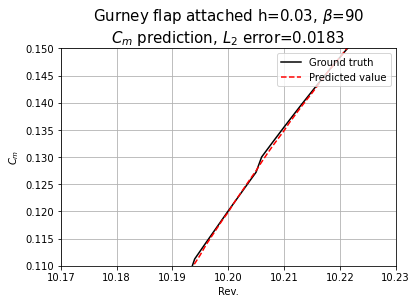

In [87]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0354


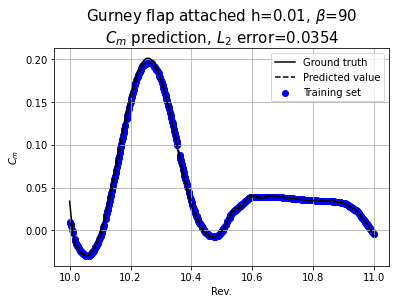

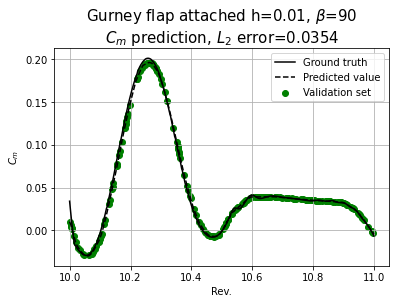

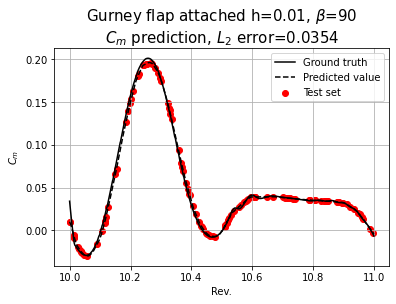

L2 error of Cm: 0.0383


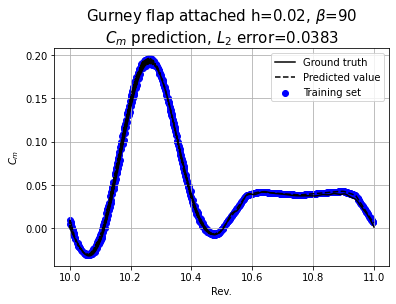

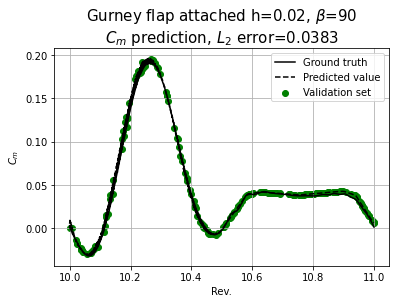

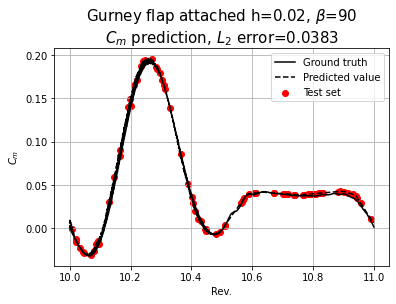

L2 error of Cm: 0.0183


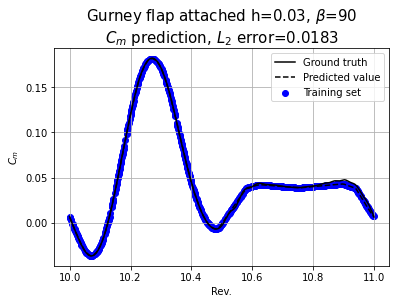

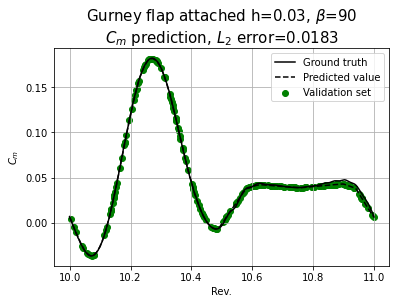

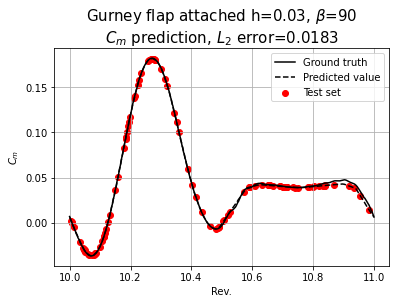

In [93]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    # Cm graph plot
    ## Training dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

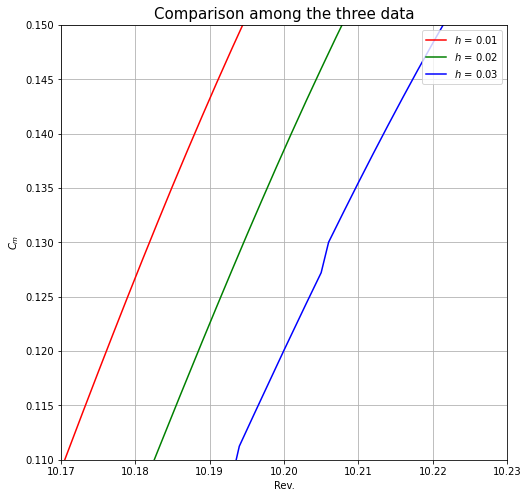

In [90]:
plt.figure(figsize=(8,8))
plt.plot(t[:1000], cm[:1000], 'r-', label='$h$ = 0.01')
plt.plot(t[:1000], cm[1000:2000], 'g-', label='$h$ = 0.02')
plt.plot(t[:1000], cm[2000:3000], 'b-', label='$h$ = 0.03')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title('Comparison among the three data', fontsize=15)        
plt.legend(loc='upper right')
plt.xlim([10.17, 10.23])
plt.ylim([0.11, 0.15])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()